In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.5.1 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
assert torch.__version__.startswith("1.5")

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("datasets/balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

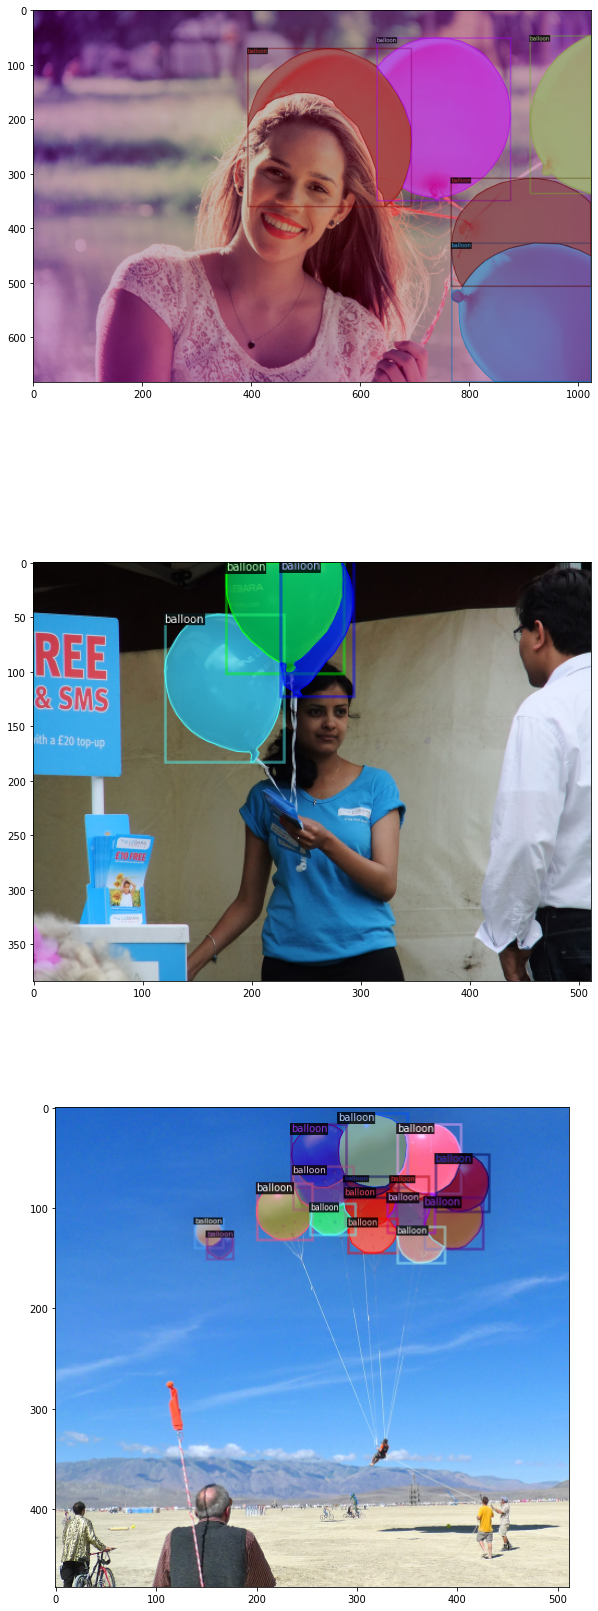

In [5]:
dataset_dicts = get_balloon_dicts("datasets/balloon/train")
plt.figure(figsize=(10, 30))
for index,d in enumerate(random.sample(dataset_dicts, 3)):
    img = cv2.imread(d["file_name"])
    # cv2 images are bgr, so they are changed to rgb using img[:,:,::-1]
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    imgs = out.get_image()
    plt.subplot(3,1,index+1)
    plt.imshow(imgs)

In [6]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/10 09:53:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[07/10 09:53:31 d2.data.build]: Removed 0 images with no usable annotations. 61 images left.
[07/10 09:53:31 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 255          |
|            |              |
[07/10 09:53:31 d2.data.common]: Serializing 61 elements to byte tensors and concatenating them all ...
[07/10 09:53:31 d2.data.common]: Serialized dataset takes 0.17 MiB
[07/10 09:53:31 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/10 09:53:31 d2.data.build]: Using training sampler TrainingSampler


Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[07/10 09:53:31 d2.engine.train_loop]: Starting training from iteration 0
[07/10 09:53:36 d2.utils.events]:  eta: 0:01:02  iter: 19  total_loss: 2.106  loss_cls: 0.690  loss_box_reg: 0.556  loss_mask: 0.701  loss_rpn_cls: 0.044  loss_rpn_loc: 0.007  time: 0.2276  data_time: 0.0297  lr: 0.000005  max_mem: 2761M
[07/10 09:53:41 d2.utils.events]:  eta: 0:00:58  iter: 39  total_loss: 2.033  loss_cls: 0.655  loss_box_reg: 0.664  loss_mask: 0.672  loss_rpn_cls: 0.041  loss_rpn_loc: 0.006  time: 0.2287  data_time: 0.0082  lr: 0.000010  max_mem: 2761M
[07/10 09:53:45 d2.utils.events]:  eta: 0:00:53  iter: 59  total_loss: 1.910  loss_cls: 0.575  loss_box_reg: 0.621  loss_mask: 0.616  loss_rpn_cls: 0.040  loss_rpn_loc: 0.012  time: 0.2231  data_time: 0.0066  lr: 0.000015  max_mem: 2761M
[07/10 09:53:50 d2.utils.events]:  eta: 0:00:49  iter: 79  total_loss: 1.797  loss_cls: 0.510  loss_box_reg: 0.687  loss_mask: 0.550  loss_rpn_cls: 0.052  loss_rpn_loc: 0.014  time: 0.2255  data_time: 0.0059  lr:

In [7]:
# Look at training curves in tensorboard:
# jupyter users need to load the TensorBoard extensions
%load_ext tensorboard
# draw the tensorboard
%tensorboard --logdir output

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

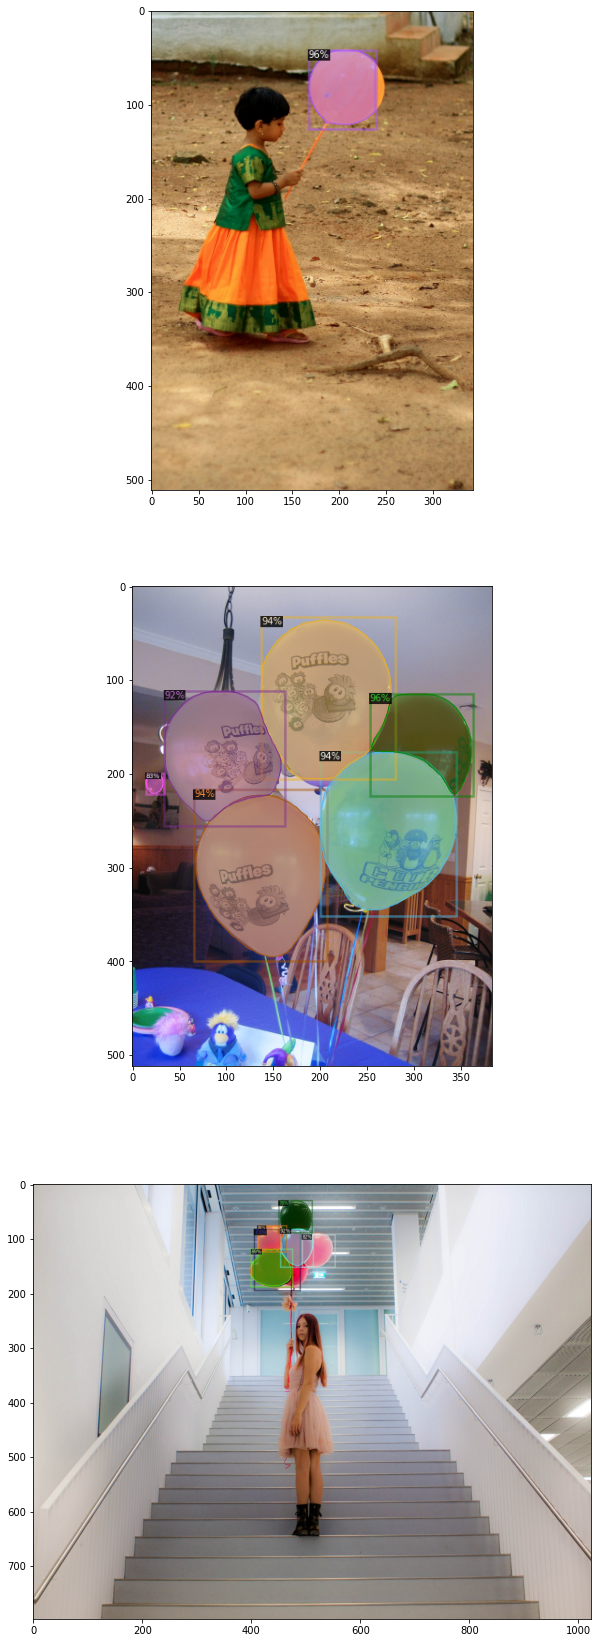

In [15]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("datasets/balloon/val")
plt.figure(figsize=(10, 30))
for index, d in enumerate(random.sample(dataset_dicts, 3)):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    imgs = out.get_image()
    plt.subplot(3,1,index+1)
    plt.imshow(imgs)

In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

[07/10 14:14:37 d2.evaluation.coco_evaluation]: 'balloon_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/10 14:14:37 d2.data.datasets.coco]: Converting annotations of dataset 'balloon_val' to COCO format ...)
[07/10 14:14:38 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/10 14:14:38 d2.data.datasets.coco]: Conversion finished, #images: 13, #annotations: 50
[07/10 14:14:38 d2.data.datasets.coco]: Caching COCO format annotations at './output/balloon_val_coco_format.json' ...
[07/10 14:14:38 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[07/10 14:14:38 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[07/10 14:14:38 d2.data.common]: Serialized dataset takes 0.04 MiB
[07/10 14:14:38 d2.data.dataset_mapper]: Augmentations used in trai